In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})
from glob import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Populating the interactive namespace from numpy and matplotlib


## Loading trajectory data

In [3]:
# LOAD TOPOLOGY
topfile = './backbone/backbone.pdb'
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.dimension()

3760

In [4]:
traj_list = glob('./backbone/*2ns.dcd')
# traj_list = ['backbone/2agy-310k-1atm-prod1.2-backbone-2ns.dcd'] 
inp = coor.source(traj_list, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',2./ (inp.trajectory_length(0)),'ns')
print('number of dimension = ',inp.dimension())

('number of trajectories = ', 100)
('trajectory length = ', 2000)
('trajectory time step = ', 0.001, 'ns')
('number of dimension = ', 3760)


## TICA analysis

In [5]:
tica_obj = coor.tica(inp, lag=1000, var_cutoff=0.9, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())


('TICA dimension ', 22)


In [6]:
tica_obj.cumvar

array([ 0.06113656,  0.1214623 ,  0.18099031,  0.23927352,  0.29666079,
        0.35252767,  0.40753185,  0.46137102,  0.51092452,  0.55490898,
        0.59632305,  0.63456562,  0.67143604,  0.70676396,  0.74079767,
        0.77316256,  0.80463096,  0.83304159,  0.85806722,  0.88049031,
        0.89365333,  0.90570464,  0.91641191,  0.92488734,  0.93288142,
        0.93951753,  0.94592007,  0.95177508,  0.9571593 ,  0.96168134,
        0.96598686,  0.96978257,  0.97306155,  0.97626932,  0.97895482,
        0.98135081,  0.98332846,  0.98473825,  0.98612977,  0.98731904,
        0.98828141,  0.98915838,  0.9900171 ,  0.99076841,  0.99149125,
        0.9921477 ,  0.99278605,  0.99329253,  0.99377612,  0.99424858,
        0.99469463,  0.99508739,  0.99546233,  0.99583218,  0.99614626,
        0.9964505 ,  0.99674305,  0.99702064,  0.99729705,  0.99752063,
        0.99773737,  0.99793655,  0.99809468,  0.99825269,  0.99840658,
        0.99855529,  0.99866559,  0.99877496,  0.99887847,  0.99

In [7]:
# here we do a little trick to ensure that eigenvectors always have the same sign structure.
# That's irrelevant to the analysis and just nicer plots - you can ignore it.
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1


In [8]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

('number of trajectories = ', 100)
('number of frames = ', 2000)
('number of dimensions = ', 22)


(200000, 22)


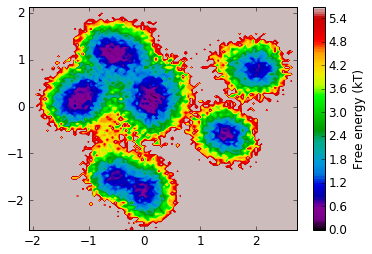

In [9]:
print(np.vstack(Y).shape)
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);

([<matplotlib.axis.YTick at 0x10ea46510>,
 <a list of 4 Text yticklabel objects>)

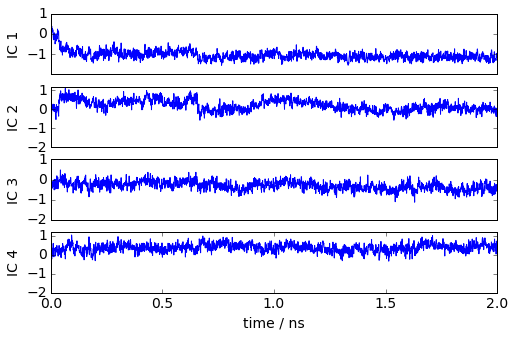

In [15]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.001
figure(figsize(8,5))
ax1=plt.subplot(411)
x = dt*np.arange(Y[0].shape[0])
plot(x, Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks(np.arange(-1, 2, 1))
ax1=plt.subplot(412)
plot(x, Y[0][:,1]); ylabel('IC 2'); xticks([]);  yticks(np.arange(-2, 2, 1))
ax1=plt.subplot(413)
plot(x, Y[0][:,2]); ylabel('IC 3');xticks([]); yticks(np.arange(-2, 2, 1))
ax1=plt.subplot(414)
plot(x, Y[0][:,3]); xlabel('time / ns'); ylabel('IC 4'); yticks(np.arange(-2, 2, 1))

## K-means clustering

In [11]:
n_clusters = 10     # number of k-means clusters
clustering = coor.cluster_kmeans(Y,k=n_clusters)


20-01-17 19:55:35 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [12]:
dtrajs = clustering.dtrajs
print(len(dtrajs))

100


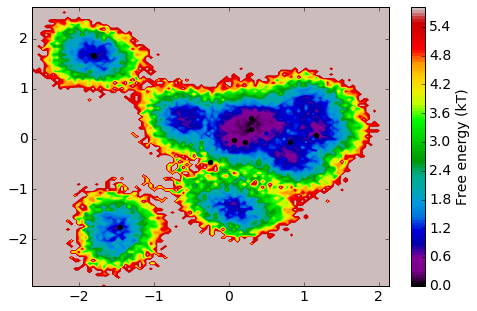

In [13]:
i, j = 1,3

mplt.plot_free_energy(np.vstack(Y)[:,i], np.vstack(Y)[:,j])
cc_x = clustering.clustercenters[:,i]
cc_y = clustering.clustercenters[:,j]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

20-01-17 19:55:37 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


(0, 1000)

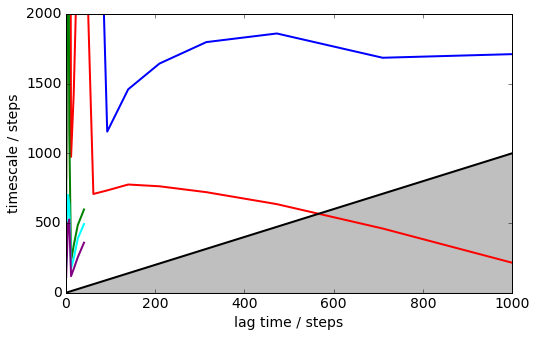

In [14]:
its = msm.timescales_msm(dtrajs, lags=1500, nits=5)
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
ylim(0,2000); xlim(0,1000)